In [1]:
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.3.1
2.4.0


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

from tensorflow.keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100, use_bias=False,input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(50, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(10, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, early_stopping])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4100      
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5000      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0

943/943 [==============================] - 2s 2ms/step - loss: 0.3817 - accuracy: 0.8180 - val_loss: 0.3438 - val_accuracy: 0.8444
Epoch 44/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3832 - accuracy: 0.8199 - val_loss: 0.3440 - val_accuracy: 0.8444
Epoch 45/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3835 - accuracy: 0.8186 - val_loss: 0.3438 - val_accuracy: 0.8453
Epoch 46/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3873 - accuracy: 0.8175 - val_loss: 0.3439 - val_accuracy: 0.8444
Epoch 47/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3823 - accuracy: 0.8160 - val_loss: 0.3438 - val_accuracy: 0.8444
Epoch 48/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3865 - accuracy: 0.8179 - val_loss: 0.3437 - val_accuracy: 0.8446
Epoch 49/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3829 - accuracy: 0.8177 - val_loss: 0.3443 - val_accuracy: 0.8442
Epoch

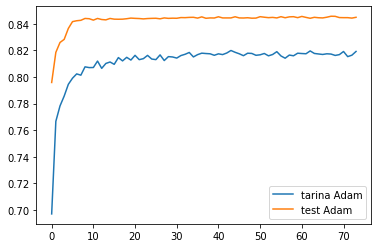

In [5]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()

# Zad.
Do poniższego modelu dodaj
 
```python
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
```

w każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

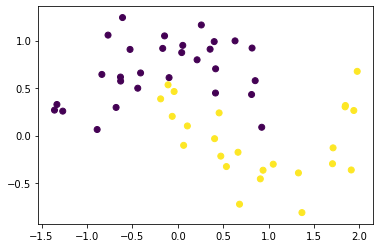

In [6]:
from sklearn.datasets import make_moons
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)
# split into train and test
# n_train = 30
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=2)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [7]:
from tensorflow.keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_6 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 0s 71ms/step - loss: 0.8002 - accuracy: 0.4151 - val_loss: 0.6733 - val_accuracy: 0.5532
Epoch 2/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.6780 - accuracy: 0.5094 - val_

2/2 [==============================] - 0s 12ms/step - loss: 0.1893 - accuracy: 0.9245 - val_loss: 0.4759 - val_accuracy: 0.8298
Epoch 53/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.1892 - accuracy: 0.9057 - val_loss: 0.4826 - val_accuracy: 0.8298
Epoch 54/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.1873 - accuracy: 0.9057 - val_loss: 0.4718 - val_accuracy: 0.8298
Epoch 55/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.1847 - accuracy: 0.9057 - val_loss: 0.4628 - val_accuracy: 0.8298
Epoch 56/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.1853 - accuracy: 0.9245 - val_loss: 0.4511 - val_accuracy: 0.8298
Epoch 57/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.1846 - accuracy: 0.9245 - val_loss: 0.4555 - val_accuracy: 0.8298
Epoch 58/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.1823 - accuracy: 0.9245 - val_loss: 0.4468 - val_accuracy: 0.8298
Epoch 59/1000
2/2 [=

Epoch 110/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0755 - accuracy: 0.9811 - val_loss: 0.2476 - val_accuracy: 0.8936
Epoch 111/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0731 - accuracy: 0.9811 - val_loss: 0.2336 - val_accuracy: 0.9149
Epoch 112/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0717 - accuracy: 0.9811 - val_loss: 0.2259 - val_accuracy: 0.9149
Epoch 113/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0690 - accuracy: 0.9811 - val_loss: 0.2295 - val_accuracy: 0.9149
Epoch 114/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0681 - accuracy: 0.9811 - val_loss: 0.2348 - val_accuracy: 0.9149
Epoch 115/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0657 - accuracy: 0.9811 - val_loss: 0.2275 - val_accuracy: 0.9149
Epoch 116/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0630 - accuracy: 0.9811 - val_loss: 0.2132 - val_accuracy: 0.9149

2/2 [==============================] - 0s 12ms/step - loss: 0.0213 - accuracy: 1.0000 - val_loss: 0.1821 - val_accuracy: 0.9149
Epoch 168/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0206 - accuracy: 1.0000 - val_loss: 0.1816 - val_accuracy: 0.9149
Epoch 169/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0191 - accuracy: 1.0000 - val_loss: 0.1839 - val_accuracy: 0.9149
Epoch 170/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0192 - accuracy: 1.0000 - val_loss: 0.1837 - val_accuracy: 0.9149
Epoch 171/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0189 - accuracy: 1.0000 - val_loss: 0.1804 - val_accuracy: 0.9149
Epoch 172/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0181 - accuracy: 1.0000 - val_loss: 0.1775 - val_accuracy: 0.8936
Epoch 173/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0181 - accuracy: 1.0000 - val_loss: 0.1760 - val_accuracy: 0.8936
Epoch 174/1000

2/2 [==============================] - 0s 12ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.1782 - val_accuracy: 0.9149
Epoch 225/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.1790 - val_accuracy: 0.9362
Epoch 226/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.1785 - val_accuracy: 0.9362
Epoch 227/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.1778 - val_accuracy: 0.9149
Epoch 228/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.1768 - val_accuracy: 0.9149
Epoch 229/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.1774 - val_accuracy: 0.9149
Epoch 230/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.1779 - val_accuracy: 0.9149
Epoch 231/1000

2/2 [==============================] - 0s 12ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.1953 - val_accuracy: 0.9149
Epoch 282/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.1968 - val_accuracy: 0.9149
Epoch 283/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.1987 - val_accuracy: 0.9149
Epoch 284/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.1989 - val_accuracy: 0.9149
Epoch 285/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.2002 - val_accuracy: 0.9149
Epoch 286/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.1997 - val_accuracy: 0.9149
Epoch 287/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.1998 - val_accuracy: 0.9149
Epoch 288/1000

2/2 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2102 - val_accuracy: 0.9149
Epoch 339/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2098 - val_accuracy: 0.9149
Epoch 340/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2108 - val_accuracy: 0.9149
Epoch 341/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2114 - val_accuracy: 0.9149
Epoch 342/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2115 - val_accuracy: 0.9149
Epoch 343/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2123 - val_accuracy: 0.9149
Epoch 344/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2129 - val_accuracy: 0.9149
Epoch 345/1000

2/2 [==============================] - 0s 13ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2223 - val_accuracy: 0.9149
Epoch 396/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2243 - val_accuracy: 0.9149
Epoch 397/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2259 - val_accuracy: 0.9149
Epoch 398/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2267 - val_accuracy: 0.9149
Epoch 399/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2270 - val_accuracy: 0.9149
Epoch 400/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2267 - val_accuracy: 0.9149
Epoch 401/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2262 - val_accuracy: 0.9149
Epoch 402/1000

2/2 [==============================] - 0s 12ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2365 - val_accuracy: 0.9149
Epoch 453/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2368 - val_accuracy: 0.9149
Epoch 454/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2365 - val_accuracy: 0.9149
Epoch 455/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2366 - val_accuracy: 0.9149
Epoch 456/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2362 - val_accuracy: 0.9149
Epoch 457/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2372 - val_accuracy: 0.9149
Epoch 458/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2381 - val_accuracy: 0.9149
Epoch 459/1000

Epoch 509/1000
2/2 [==============================] - 0s 16ms/step - loss: 8.8514e-04 - accuracy: 1.0000 - val_loss: 0.2445 - val_accuracy: 0.9149
Epoch 510/1000
2/2 [==============================] - 0s 14ms/step - loss: 9.0259e-04 - accuracy: 1.0000 - val_loss: 0.2449 - val_accuracy: 0.9149
Epoch 511/1000
2/2 [==============================] - 0s 13ms/step - loss: 9.1131e-04 - accuracy: 1.0000 - val_loss: 0.2440 - val_accuracy: 0.9149
Epoch 512/1000
2/2 [==============================] - 0s 14ms/step - loss: 8.7190e-04 - accuracy: 1.0000 - val_loss: 0.2446 - val_accuracy: 0.9149
Epoch 513/1000
2/2 [==============================] - 0s 14ms/step - loss: 8.6725e-04 - accuracy: 1.0000 - val_loss: 0.2452 - val_accuracy: 0.9149
Epoch 514/1000
2/2 [==============================] - 0s 13ms/step - loss: 8.6207e-04 - accuracy: 1.0000 - val_loss: 0.2460 - val_accuracy: 0.9149
Epoch 515/1000
2/2 [==============================] - 0s 15ms/step - loss: 8.5758e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 565/1000
2/2 [==============================] - 0s 12ms/step - loss: 6.9894e-04 - accuracy: 1.0000 - val_loss: 0.2607 - val_accuracy: 0.9149
Epoch 566/1000
2/2 [==============================] - 0s 14ms/step - loss: 7.1352e-04 - accuracy: 1.0000 - val_loss: 0.2603 - val_accuracy: 0.9149
Epoch 567/1000
2/2 [==============================] - 0s 13ms/step - loss: 7.0412e-04 - accuracy: 1.0000 - val_loss: 0.2598 - val_accuracy: 0.9149
Epoch 568/1000
2/2 [==============================] - 0s 15ms/step - loss: 6.9126e-04 - accuracy: 1.0000 - val_loss: 0.2597 - val_accuracy: 0.9149
Epoch 569/1000
2/2 [==============================] - 0s 14ms/step - loss: 6.9957e-04 - accuracy: 1.0000 - val_loss: 0.2577 - val_accuracy: 0.9149
Epoch 570/1000
2/2 [==============================] - 0s 13ms/step - loss: 6.7976e-04 - accuracy: 1.0000 - val_loss: 0.2565 - val_accuracy: 0.9149
Epoch 571/1000
2/2 [==============================] - 0s 13ms/step - loss: 6.6610e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 621/1000
2/2 [==============================] - 0s 16ms/step - loss: 5.1940e-04 - accuracy: 1.0000 - val_loss: 0.2662 - val_accuracy: 0.9149
Epoch 622/1000
2/2 [==============================] - 0s 17ms/step - loss: 5.1761e-04 - accuracy: 1.0000 - val_loss: 0.2669 - val_accuracy: 0.9149
Epoch 623/1000
2/2 [==============================] - 0s 13ms/step - loss: 5.2740e-04 - accuracy: 1.0000 - val_loss: 0.2673 - val_accuracy: 0.9149
Epoch 624/1000
2/2 [==============================] - 0s 15ms/step - loss: 5.1483e-04 - accuracy: 1.0000 - val_loss: 0.2665 - val_accuracy: 0.9149
Epoch 625/1000
2/2 [==============================] - 0s 15ms/step - loss: 5.1202e-04 - accuracy: 1.0000 - val_loss: 0.2661 - val_accuracy: 0.9149
Epoch 626/1000
2/2 [==============================] - 0s 17ms/step - loss: 5.0863e-04 - accuracy: 1.0000 - val_loss: 0.2648 - val_accuracy: 0.9149
Epoch 627/1000
2/2 [==============================] - 0s 18ms/step - loss: 5.1244e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 677/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.1550e-04 - accuracy: 1.0000 - val_loss: 0.2786 - val_accuracy: 0.9149
Epoch 678/1000
2/2 [==============================] - 0s 15ms/step - loss: 4.2055e-04 - accuracy: 1.0000 - val_loss: 0.2798 - val_accuracy: 0.9149
Epoch 679/1000
2/2 [==============================] - 0s 12ms/step - loss: 4.2630e-04 - accuracy: 1.0000 - val_loss: 0.2798 - val_accuracy: 0.9149
Epoch 680/1000
2/2 [==============================] - 0s 15ms/step - loss: 4.1676e-04 - accuracy: 1.0000 - val_loss: 0.2798 - val_accuracy: 0.9149
Epoch 681/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.1425e-04 - accuracy: 1.0000 - val_loss: 0.2794 - val_accuracy: 0.9149
Epoch 682/1000
2/2 [==============================] - 0s 13ms/step - loss: 4.0975e-04 - accuracy: 1.0000 - val_loss: 0.2788 - val_accuracy: 0.9149
Epoch 683/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.0557e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 733/1000
2/2 [==============================] - 0s 13ms/step - loss: 3.4508e-04 - accuracy: 1.0000 - val_loss: 0.2837 - val_accuracy: 0.9149
Epoch 734/1000
2/2 [==============================] - 0s 13ms/step - loss: 3.3466e-04 - accuracy: 1.0000 - val_loss: 0.2839 - val_accuracy: 0.9149
Epoch 735/1000
2/2 [==============================] - 0s 14ms/step - loss: 3.3995e-04 - accuracy: 1.0000 - val_loss: 0.2843 - val_accuracy: 0.9149
Epoch 736/1000
2/2 [==============================] - 0s 13ms/step - loss: 3.4089e-04 - accuracy: 1.0000 - val_loss: 0.2837 - val_accuracy: 0.9149
Epoch 737/1000
2/2 [==============================] - 0s 14ms/step - loss: 3.3126e-04 - accuracy: 1.0000 - val_loss: 0.2841 - val_accuracy: 0.9149
Epoch 738/1000
2/2 [==============================] - 0s 13ms/step - loss: 3.3655e-04 - accuracy: 1.0000 - val_loss: 0.2848 - val_accuracy: 0.9149
Epoch 739/1000
2/2 [==============================] - 0s 12ms/step - loss: 3.2865e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 789/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.7926e-04 - accuracy: 1.0000 - val_loss: 0.2916 - val_accuracy: 0.9149
Epoch 790/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.7956e-04 - accuracy: 1.0000 - val_loss: 0.2921 - val_accuracy: 0.9149
Epoch 791/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.7482e-04 - accuracy: 1.0000 - val_loss: 0.2935 - val_accuracy: 0.9149
Epoch 792/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.7485e-04 - accuracy: 1.0000 - val_loss: 0.2956 - val_accuracy: 0.9149
Epoch 793/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.7509e-04 - accuracy: 1.0000 - val_loss: 0.2968 - val_accuracy: 0.9149
Epoch 794/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.8004e-04 - accuracy: 1.0000 - val_loss: 0.2980 - val_accuracy: 0.9149
Epoch 795/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.8029e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 845/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.3541e-04 - accuracy: 1.0000 - val_loss: 0.3045 - val_accuracy: 0.9149
Epoch 846/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.4104e-04 - accuracy: 1.0000 - val_loss: 0.3056 - val_accuracy: 0.9149
Epoch 847/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.4448e-04 - accuracy: 1.0000 - val_loss: 0.3058 - val_accuracy: 0.9149
Epoch 848/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.4679e-04 - accuracy: 1.0000 - val_loss: 0.3049 - val_accuracy: 0.9149
Epoch 849/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.3738e-04 - accuracy: 1.0000 - val_loss: 0.3041 - val_accuracy: 0.9149
Epoch 850/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.4095e-04 - accuracy: 1.0000 - val_loss: 0.3025 - val_accuracy: 0.9149
Epoch 851/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.3458e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 901/1000
2/2 [==============================] - 0s 13ms/step - loss: 1.9724e-04 - accuracy: 1.0000 - val_loss: 0.3066 - val_accuracy: 0.9149
Epoch 902/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.9935e-04 - accuracy: 1.0000 - val_loss: 0.3068 - val_accuracy: 0.9149
Epoch 903/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.0069e-04 - accuracy: 1.0000 - val_loss: 0.3079 - val_accuracy: 0.9149
Epoch 904/1000
2/2 [==============================] - 0s 13ms/step - loss: 1.9532e-04 - accuracy: 1.0000 - val_loss: 0.3081 - val_accuracy: 0.9149
Epoch 905/1000
2/2 [==============================] - 0s 13ms/step - loss: 1.9497e-04 - accuracy: 1.0000 - val_loss: 0.3082 - val_accuracy: 0.9149
Epoch 906/1000
2/2 [==============================] - 0s 15ms/step - loss: 1.9697e-04 - accuracy: 1.0000 - val_loss: 0.3080 - val_accuracy: 0.9149
Epoch 907/1000
2/2 [==============================] - ETA: 0s - loss: 3.1160e-04 - accuracy: 1.00 - 0s 15ms/step - los

2/2 [==============================] - 0s 14ms/step - loss: 1.7187e-04 - accuracy: 1.0000 - val_loss: 0.3129 - val_accuracy: 0.9149
Epoch 957/1000
2/2 [==============================] - 0s 13ms/step - loss: 1.6941e-04 - accuracy: 1.0000 - val_loss: 0.3123 - val_accuracy: 0.9149
Epoch 958/1000
2/2 [==============================] - 0s 13ms/step - loss: 1.6924e-04 - accuracy: 1.0000 - val_loss: 0.3122 - val_accuracy: 0.9149
Epoch 959/1000
2/2 [==============================] - 0s 17ms/step - loss: 1.7123e-04 - accuracy: 1.0000 - val_loss: 0.3121 - val_accuracy: 0.9149
Epoch 960/1000
2/2 [==============================] - 0s 17ms/step - loss: 1.7184e-04 - accuracy: 1.0000 - val_loss: 0.3134 - val_accuracy: 0.9149
Epoch 961/1000
2/2 [==============================] - 0s 13ms/step - loss: 1.6745e-04 - accuracy: 1.0000 - val_loss: 0.3138 - val_accuracy: 0.9149
Epoch 962/1000
2/2 [==============================] - 0s 13ms/step - loss: 1.6949e-04 - accuracy: 1.0000 - val_loss: 0.3144 - val_acc

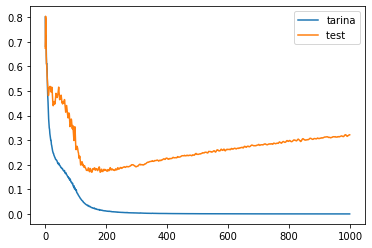

In [8]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


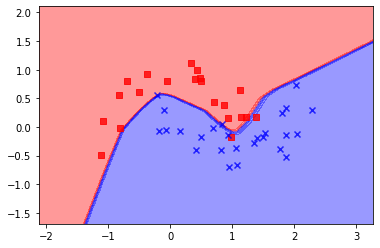

In [9]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

In [10]:
from tensorflow.keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam_1 = History()
model = Sequential()
model.add(Dense(1000, use_bias=False,input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(500, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(200, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_1])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1000)              2000      
_________________________________________________________________
batch_normalization_3 (Batch (None, 1000)              4000      
_________________________________________________________________
activation_3 (Activation)    (None, 1000)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               500000    
_________________________________________________________________
batch_normalization_4 (Batch (None, 500)               2000      
_________________________________________________________________
activation_4 (Activation)    (None, 500)              

2/2 [==============================] - 0s 14ms/step - loss: 0.3603 - accuracy: 0.8679 - val_loss: 0.6115 - val_accuracy: 0.5532
Epoch 45/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2854 - accuracy: 0.9057 - val_loss: 0.6097 - val_accuracy: 0.5532
Epoch 46/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2491 - accuracy: 0.8868 - val_loss: 0.6082 - val_accuracy: 0.5532
Epoch 47/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.3068 - accuracy: 0.9245 - val_loss: 0.6049 - val_accuracy: 0.5532
Epoch 48/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2579 - accuracy: 0.8679 - val_loss: 0.6038 - val_accuracy: 0.5532
Epoch 49/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2932 - accuracy: 0.8868 - val_loss: 0.6035 - val_accuracy: 0.5532
Epoch 50/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2774 - accuracy: 0.9057 - val_loss: 0.6038 - val_accuracy: 0.5532
Epoch 51/1000
2/2 [=

Epoch 102/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.3486 - accuracy: 0.8302 - val_loss: 0.5471 - val_accuracy: 0.7660
Epoch 103/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2864 - accuracy: 0.8491 - val_loss: 0.5420 - val_accuracy: 0.7660
Epoch 104/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.3571 - accuracy: 0.8868 - val_loss: 0.5370 - val_accuracy: 0.7447
Epoch 105/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.2512 - accuracy: 0.9057 - val_loss: 0.5308 - val_accuracy: 0.7447
Epoch 106/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2590 - accuracy: 0.9245 - val_loss: 0.5250 - val_accuracy: 0.7447
Epoch 107/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2398 - accuracy: 0.9434 - val_loss: 0.5191 - val_accuracy: 0.7447
Epoch 108/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.2498 - accuracy: 0.9057 - val_loss: 0.5140 - val_accuracy: 0.7447

2/2 [==============================] - 0s 22ms/step - loss: 0.3095 - accuracy: 0.8491 - val_loss: 0.4541 - val_accuracy: 0.7447
Epoch 160/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.2957 - accuracy: 0.8679 - val_loss: 0.4546 - val_accuracy: 0.7447
Epoch 161/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2652 - accuracy: 0.8679 - val_loss: 0.4542 - val_accuracy: 0.7447
Epoch 162/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2456 - accuracy: 0.8868 - val_loss: 0.4528 - val_accuracy: 0.7447
Epoch 163/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.2580 - accuracy: 0.9245 - val_loss: 0.4518 - val_accuracy: 0.7447
Epoch 164/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.2253 - accuracy: 0.9245 - val_loss: 0.4515 - val_accuracy: 0.7447
Epoch 165/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.2419 - accuracy: 0.8679 - val_loss: 0.4495 - val_accuracy: 0.7447
Epoch 166/1000

2/2 [==============================] - 0s 15ms/step - loss: 0.3126 - accuracy: 0.8868 - val_loss: 0.4492 - val_accuracy: 0.7660
Epoch 217/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.3189 - accuracy: 0.8679 - val_loss: 0.4471 - val_accuracy: 0.7660
Epoch 218/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2660 - accuracy: 0.8679 - val_loss: 0.4453 - val_accuracy: 0.7660
Epoch 219/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.2630 - accuracy: 0.8868 - val_loss: 0.4432 - val_accuracy: 0.7660
Epoch 220/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2817 - accuracy: 0.8679 - val_loss: 0.4421 - val_accuracy: 0.7660
Epoch 221/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2758 - accuracy: 0.9057 - val_loss: 0.4425 - val_accuracy: 0.7660
Epoch 222/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2580 - accuracy: 0.8868 - val_loss: 0.4421 - val_accuracy: 0.7447
Epoch 223/1000

2/2 [==============================] - 0s 17ms/step - loss: 0.2521 - accuracy: 0.8868 - val_loss: 0.4794 - val_accuracy: 0.7872
Epoch 274/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2404 - accuracy: 0.9057 - val_loss: 0.4722 - val_accuracy: 0.7872
Epoch 275/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2410 - accuracy: 0.9057 - val_loss: 0.4642 - val_accuracy: 0.7872
Epoch 276/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2922 - accuracy: 0.9057 - val_loss: 0.4597 - val_accuracy: 0.7872
Epoch 277/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.3312 - accuracy: 0.8302 - val_loss: 0.4509 - val_accuracy: 0.7872
Epoch 278/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2504 - accuracy: 0.8868 - val_loss: 0.4431 - val_accuracy: 0.7872
Epoch 279/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1638 - accuracy: 0.9245 - val_loss: 0.4366 - val_accuracy: 0.7872
Epoch 280/1000

2/2 [==============================] - 0s 13ms/step - loss: 0.2592 - accuracy: 0.9245 - val_loss: 0.4843 - val_accuracy: 0.8085
Epoch 331/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2581 - accuracy: 0.8868 - val_loss: 0.4793 - val_accuracy: 0.8085
Epoch 332/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2631 - accuracy: 0.8679 - val_loss: 0.4736 - val_accuracy: 0.8085
Epoch 333/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2723 - accuracy: 0.9057 - val_loss: 0.4703 - val_accuracy: 0.8085
Epoch 334/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.1983 - accuracy: 0.9057 - val_loss: 0.4673 - val_accuracy: 0.8085
Epoch 335/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.3619 - accuracy: 0.7925 - val_loss: 0.4670 - val_accuracy: 0.8085
Epoch 336/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.2679 - accuracy: 0.8679 - val_loss: 0.4719 - val_accuracy: 0.8085
Epoch 337/1000

2/2 [==============================] - 0s 12ms/step - loss: 0.2290 - accuracy: 0.8868 - val_loss: 0.4237 - val_accuracy: 0.8085
Epoch 388/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2821 - accuracy: 0.8868 - val_loss: 0.4243 - val_accuracy: 0.8085
Epoch 389/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2549 - accuracy: 0.9057 - val_loss: 0.4235 - val_accuracy: 0.8085
Epoch 390/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2193 - accuracy: 0.9057 - val_loss: 0.4235 - val_accuracy: 0.8085
Epoch 391/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2374 - accuracy: 0.8679 - val_loss: 0.4201 - val_accuracy: 0.8085
Epoch 392/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2611 - accuracy: 0.8868 - val_loss: 0.4186 - val_accuracy: 0.8085
Epoch 393/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2451 - accuracy: 0.8868 - val_loss: 0.4165 - val_accuracy: 0.8085
Epoch 394/1000

2/2 [==============================] - 0s 13ms/step - loss: 0.2385 - accuracy: 0.9245 - val_loss: 0.4357 - val_accuracy: 0.8085
Epoch 445/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2384 - accuracy: 0.8868 - val_loss: 0.4458 - val_accuracy: 0.8085
Epoch 446/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2399 - accuracy: 0.9245 - val_loss: 0.4628 - val_accuracy: 0.8085
Epoch 447/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2286 - accuracy: 0.8868 - val_loss: 0.4779 - val_accuracy: 0.7872
Epoch 448/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.2496 - accuracy: 0.9057 - val_loss: 0.4874 - val_accuracy: 0.7872
Epoch 449/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.4448 - accuracy: 0.8302 - val_loss: 0.4850 - val_accuracy: 0.7872
Epoch 450/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2249 - accuracy: 0.9245 - val_loss: 0.4852 - val_accuracy: 0.7872
Epoch 451/1000

2/2 [==============================] - 0s 14ms/step - loss: 0.1675 - accuracy: 0.9245 - val_loss: 0.4305 - val_accuracy: 0.8298
Epoch 502/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.3136 - accuracy: 0.8302 - val_loss: 0.4377 - val_accuracy: 0.8085
Epoch 503/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2061 - accuracy: 0.9057 - val_loss: 0.4382 - val_accuracy: 0.8085
Epoch 504/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2177 - accuracy: 0.9245 - val_loss: 0.4359 - val_accuracy: 0.8085
Epoch 505/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2300 - accuracy: 0.8868 - val_loss: 0.4340 - val_accuracy: 0.8085
Epoch 506/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.3401 - accuracy: 0.8679 - val_loss: 0.4344 - val_accuracy: 0.8085
Epoch 507/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2567 - accuracy: 0.9057 - val_loss: 0.4298 - val_accuracy: 0.8085
Epoch 508/1000

2/2 [==============================] - 0s 14ms/step - loss: 0.2176 - accuracy: 0.9057 - val_loss: 0.4249 - val_accuracy: 0.8511
Epoch 559/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2210 - accuracy: 0.9057 - val_loss: 0.4099 - val_accuracy: 0.8511
Epoch 560/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2795 - accuracy: 0.8679 - val_loss: 0.3940 - val_accuracy: 0.8511
Epoch 561/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2822 - accuracy: 0.8679 - val_loss: 0.3792 - val_accuracy: 0.8723
Epoch 562/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.4107 - accuracy: 0.8491 - val_loss: 0.3705 - val_accuracy: 0.8723
Epoch 563/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2429 - accuracy: 0.9245 - val_loss: 0.3648 - val_accuracy: 0.8511
Epoch 564/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2017 - accuracy: 0.9245 - val_loss: 0.3608 - val_accuracy: 0.8511
Epoch 565/1000

2/2 [==============================] - 0s 15ms/step - loss: 0.1913 - accuracy: 0.9245 - val_loss: 0.3162 - val_accuracy: 0.8723
Epoch 616/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2076 - accuracy: 0.9057 - val_loss: 0.3105 - val_accuracy: 0.8723
Epoch 617/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2523 - accuracy: 0.9057 - val_loss: 0.3020 - val_accuracy: 0.8723
Epoch 618/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2975 - accuracy: 0.8302 - val_loss: 0.3067 - val_accuracy: 0.8723
Epoch 619/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2501 - accuracy: 0.9434 - val_loss: 0.3161 - val_accuracy: 0.8723
Epoch 620/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.1559 - accuracy: 0.9434 - val_loss: 0.3220 - val_accuracy: 0.8723
Epoch 621/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.3145 - accuracy: 0.8491 - val_loss: 0.3203 - val_accuracy: 0.8723
Epoch 622/1000

2/2 [==============================] - 0s 14ms/step - loss: 0.1940 - accuracy: 0.9057 - val_loss: 0.3489 - val_accuracy: 0.8723
Epoch 673/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2204 - accuracy: 0.8868 - val_loss: 0.3467 - val_accuracy: 0.8723
Epoch 674/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.1692 - accuracy: 0.9434 - val_loss: 0.3432 - val_accuracy: 0.8723
Epoch 675/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2659 - accuracy: 0.8302 - val_loss: 0.3411 - val_accuracy: 0.8723
Epoch 676/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1534 - accuracy: 0.9434 - val_loss: 0.3368 - val_accuracy: 0.8723
Epoch 677/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.3082 - accuracy: 0.8491 - val_loss: 0.3378 - val_accuracy: 0.8723
Epoch 678/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1850 - accuracy: 0.9057 - val_loss: 0.3440 - val_accuracy: 0.8723
Epoch 679/1000

2/2 [==============================] - 0s 14ms/step - loss: 0.2909 - accuracy: 0.8868 - val_loss: 0.3350 - val_accuracy: 0.8723
Epoch 730/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2355 - accuracy: 0.9057 - val_loss: 0.3324 - val_accuracy: 0.8723
Epoch 731/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1931 - accuracy: 0.9057 - val_loss: 0.3257 - val_accuracy: 0.8723
Epoch 732/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1436 - accuracy: 0.9623 - val_loss: 0.3187 - val_accuracy: 0.8723
Epoch 733/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2723 - accuracy: 0.9057 - val_loss: 0.3071 - val_accuracy: 0.8723
Epoch 734/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.3901 - accuracy: 0.8302 - val_loss: 0.3000 - val_accuracy: 0.8723
Epoch 735/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2759 - accuracy: 0.9057 - val_loss: 0.2979 - val_accuracy: 0.8723
Epoch 736/1000

2/2 [==============================] - 0s 15ms/step - loss: 0.2245 - accuracy: 0.9245 - val_loss: 0.2866 - val_accuracy: 0.8723
Epoch 787/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2229 - accuracy: 0.9057 - val_loss: 0.2758 - val_accuracy: 0.8723
Epoch 788/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2194 - accuracy: 0.9057 - val_loss: 0.2706 - val_accuracy: 0.8723
Epoch 789/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2445 - accuracy: 0.9057 - val_loss: 0.2712 - val_accuracy: 0.8723
Epoch 790/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.2503 - accuracy: 0.9057 - val_loss: 0.2767 - val_accuracy: 0.8723
Epoch 791/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.1776 - accuracy: 0.9057 - val_loss: 0.2779 - val_accuracy: 0.8723
Epoch 792/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2319 - accuracy: 0.9057 - val_loss: 0.2809 - val_accuracy: 0.8723
Epoch 793/1000

2/2 [==============================] - 0s 13ms/step - loss: 0.1478 - accuracy: 0.9434 - val_loss: 0.2898 - val_accuracy: 0.8723
Epoch 844/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.1932 - accuracy: 0.9245 - val_loss: 0.3053 - val_accuracy: 0.8723
Epoch 845/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.1780 - accuracy: 0.9245 - val_loss: 0.3121 - val_accuracy: 0.8723
Epoch 846/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2556 - accuracy: 0.9245 - val_loss: 0.3161 - val_accuracy: 0.8723
Epoch 847/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2046 - accuracy: 0.9245 - val_loss: 0.3148 - val_accuracy: 0.8723
Epoch 848/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0950 - accuracy: 1.0000 - val_loss: 0.3180 - val_accuracy: 0.8723
Epoch 849/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2540 - accuracy: 0.9057 - val_loss: 0.3199 - val_accuracy: 0.8723
Epoch 850/1000

2/2 [==============================] - 0s 16ms/step - loss: 0.1852 - accuracy: 0.8868 - val_loss: 0.2713 - val_accuracy: 0.8723
Epoch 901/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2126 - accuracy: 0.9057 - val_loss: 0.2605 - val_accuracy: 0.8723
Epoch 902/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1490 - accuracy: 0.9434 - val_loss: 0.2508 - val_accuracy: 0.8723
Epoch 903/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1822 - accuracy: 0.9434 - val_loss: 0.2406 - val_accuracy: 0.8723
Epoch 904/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1704 - accuracy: 0.8868 - val_loss: 0.2345 - val_accuracy: 0.8723
Epoch 905/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1653 - accuracy: 0.9434 - val_loss: 0.2340 - val_accuracy: 0.8723
Epoch 906/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.1782 - accuracy: 0.8868 - val_loss: 0.2359 - val_accuracy: 0.8723
Epoch 907/1000

2/2 [==============================] - 0s 13ms/step - loss: 0.2320 - accuracy: 0.8679 - val_loss: 0.2236 - val_accuracy: 0.8723
Epoch 958/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.1565 - accuracy: 0.9434 - val_loss: 0.2159 - val_accuracy: 0.8723
Epoch 959/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.1291 - accuracy: 0.9434 - val_loss: 0.2090 - val_accuracy: 0.9149
Epoch 960/1000
2/2 [==============================] - ETA: 0s - loss: 0.3804 - accuracy: 0.90 - 0s 12ms/step - loss: 0.3392 - accuracy: 0.8868 - val_loss: 0.2034 - val_accuracy: 0.9362
Epoch 961/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1611 - accuracy: 0.9434 - val_loss: 0.2031 - val_accuracy: 0.9362
Epoch 962/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1837 - accuracy: 0.9434 - val_loss: 0.2057 - val_accuracy: 0.9149
Epoch 963/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2283 - accuracy: 0.9057 - val_loss: 0.

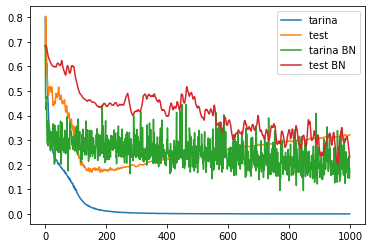

In [11]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

plt.plot(history_Adam_1.history['loss'], label = "tarina BN")
plt.plot(history_Adam_1.history['val_loss'], label = "test BN")

plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


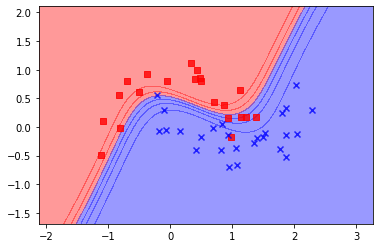

In [12]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()